In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import GridSearchCV

In [2]:
file_path = '../data/kings.xlsx'
df = pd.read_excel(file_path)

In [3]:
df.head()

,match_id,date,team1,team2,goals_team1,goals_team2,dado_number,minutes_after_dice_roll,goals_team1_after_dice,goals_team2_after_dice,Total_goals_in_dice
0,S1J3P1,2023-01-15,3,0,0,2,4,3,0,2,2
1,S1J3P2,2023-01-15,7,11,0,1,4,2,0,0,0
2,S1J3P3,2023-01-15,8,10,1,0,4,2,0,0,0
3,S1J3P4,2023-01-15,4,6,0,2,5,2,0,0,0
4,S1J3P5,2023-01-15,9,5,0,2,4,2,0,0,0


In [4]:
print(df.isnull().sum())

match_id                   0
date                       0
team1                      0
team2                      0
goals_team1                0
goals_team2                0
dado_number                0
minutes_after_dice_roll    0
goals_team1_after_dice     0
goals_team2_after_dice     0
Total_goals_in_dice        0
dtype: int64


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287 entries, 0 to 286
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   match_id                 287 non-null    object        
 1   date                     287 non-null    datetime64[ns]
 2   team1                    287 non-null    int64         
 3   team2                    287 non-null    int64         
 4   goals_team1              287 non-null    int64         
 5   goals_team2              287 non-null    int64         
 6   dado_number              287 non-null    int64         
 7   minutes_after_dice_roll  287 non-null    int64         
 8   goals_team1_after_dice   287 non-null    int64         
 9   goals_team2_after_dice   287 non-null    int64         
 10  Total_goals_in_dice      287 non-null    int64         
dtypes: datetime64[ns](1), int64(9), object(1)
memory usage: 24.8+ KB


In [6]:
df.columns

Index(['match_id', 'date', 'team1', 'team2', 'goals_team1', 'goals_team2',
       'dado_number', 'minutes_after_dice_roll', 'goals_team1_after_dice',
       'goals_team2_after_dice', 'Total_goals_in_dice'],
      dtype='object')

## Ver cuantos partidos tenemos por modalidad de dado

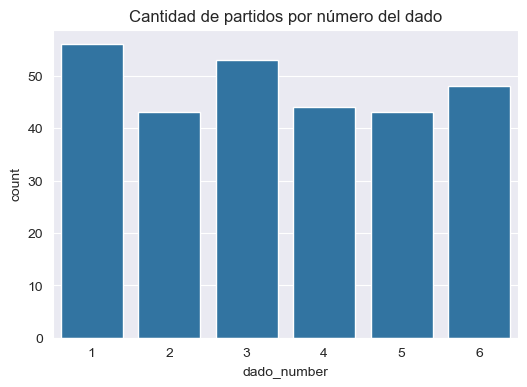

In [7]:
plt.figure(figsize=(6,4))
sns.countplot(x='dado_number', data=df)
plt.title('Cantidad de partidos por número del dado')
plt.show()

### Comparar goles antes y después del dado para los team1, solo por curiosidad

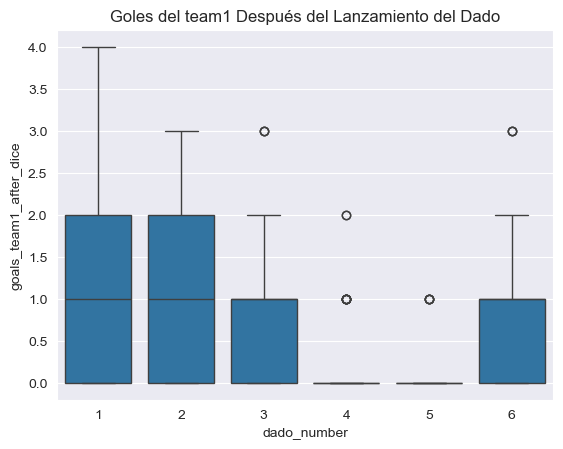

In [8]:
sns.boxplot(x='dado_number', y='goals_team1_after_dice', data=df)
plt.title('Goles del team1 Después del Lanzamiento del Dado')
plt.show()

### Comparar goles antes y después del dado para el team2, para ver si hay mucha diferencia

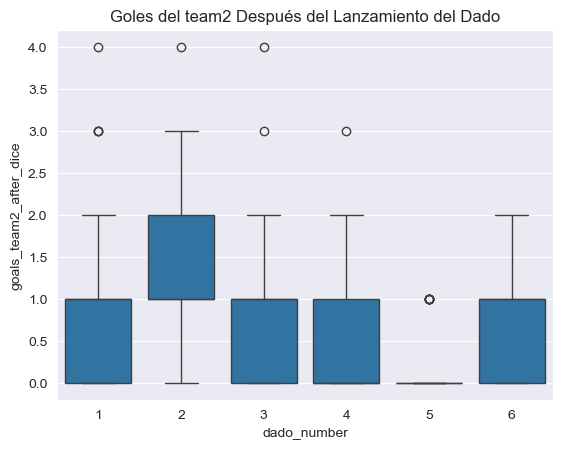

In [9]:
sns.boxplot(x='dado_number', y='goals_team2_after_dice', data=df)
plt.title('Goles del team2 Después del Lanzamiento del Dado')
plt.show()

### Ahora si los juntamos las 2 estadísticas con el total de goles

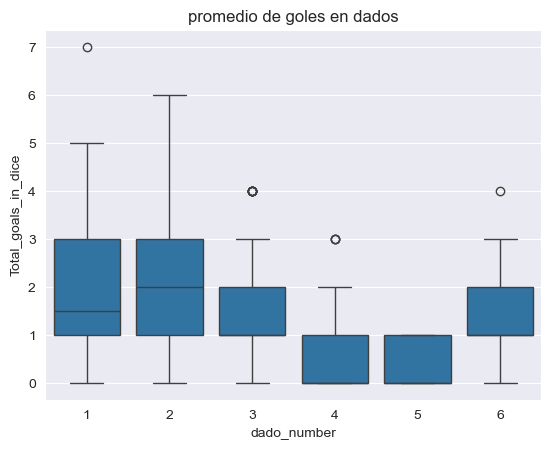

In [10]:
sns.boxplot(x='dado_number', y='Total_goals_in_dice', data=df)
plt.title('promedio de goles en dados')
plt.show()

podemos notar que si hay un outlier muy marcado en algún dado de 1 vs 1 que fueron los 7 goles que se marcaron en algún partido

## Aquí veremos las probabilidades que tienes de marcar gol si eres del team1 por número de dado

In [11]:
prob_goals_home = df.groupby('dado_number')['goals_team1_after_dice'].mean()
print("Probabilidad de goles esperados para el team1 por número de dado:\n", prob_goals_home)

Probabilidad de goles esperados para el team1 por número de dado:
 dado_number
1    0.910714
2    1.000000
3    0.811321
4    0.272727
5    0.116279
6    0.770833
Name: goals_team1_after_dice, dtype: float64


### La misma probailidad para el team2

In [12]:
prob_goals_away = df.groupby('dado_number')['goals_team2_after_dice'].mean()
print("Probabilidad de goles esperados para el team2 por número de dado:\n", prob_goals_away)

Probabilidad de goles esperados para el team2 por número de dado:
 dado_number
1    0.946429
2    1.348837
3    0.792453
4    0.454545
5    0.162791
6    0.625000
Name: goals_team2_after_dice, dtype: float64


básicamente la misma, no importa mucho el acomodo de los equipos, solo en el 2v2 cambió ligeramente más hacia el team2 pero pues la diferencia sigue siendo mínima

## Calcular el promedio de goles durante la modalidad del dado para cada número del dado

In [13]:
average_goals_by_dice = df.groupby('dado_number')['Total_goals_in_dice'].mean().reset_index()
average_goals_by_dice.columns = ['dado_number', 'avg_goals_in_dice']

In [14]:
average_goals_by_dice

,dado_number,avg_goals_in_dice
0,1,1.857143
1,2,2.348837
2,3,1.603774
3,4,0.727273
4,5,0.279070
5,6,1.395833


El promedio de goles en el 2v2 es muy marcado y se estima al menos una cantidad de 2 goles mínimo por enfrentamiento, por otro lado el 4v4 tiene un promedio muy bajo de goles esperados con menos del 0.30

#### Ahora vamos a calcular la diferencia de goles para cada equipo antes y después del dado

In [15]:
# Agregamos una nueva columna para esta diferencia
df['goal_difference_dice_team1']=df['goals_team1_after_dice'] + df['goals_team1'] - df['goals_team2_after_dice'] - df['goals_team2']
df['goal_difference_dice_team2']=df['goals_team2_after_dice'] + df['goals_team2'] - df['goals_team1_after_dice'] - df['goals_team1']

In [16]:
# Calcular el promedio de la diferencia de goles para cada equipo durante la modalidad del dado
average_goal_diff_by_team1 = df.groupby('team1')['goal_difference_dice_team1'].mean().reset_index()
average_goal_diff_by_team2 = df.groupby('team2')['goal_difference_dice_team2'].mean().reset_index()

In [17]:
# Renombrar columnas para clarificar
average_goal_diff_by_team1.columns = ['team', 'avg_goal_diff_in_dice']
average_goal_diff_by_team2.columns = ['team', 'avg_goal_diff_in_dice']

In [18]:
# Unir las estadísticas de ambos equipos
average_goal_diff_all_teams = pd.concat([average_goal_diff_by_team1, average_goal_diff_by_team2]).groupby('team').mean().reset_index()
print("Promedio de diferencia de goles para cada equipo durante la modalidad del dado:")
average_goal_diff_all_teams

Promedio de diferencia de goles para cada equipo durante la modalidad del dado:


,team,avg_goal_diff_in_dice
0,0,-0.156883
1,1,0.001515
2,2,-0.050000
3,3,-0.144963
4,4,-0.741107
5,5,-0.354167
6,6,0.637821
7,7,-0.319005
8,8,0.158654
9,9,0.193913


observaciones: 

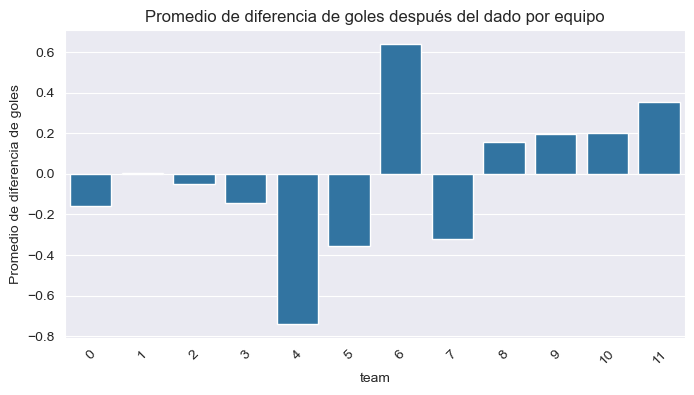

In [19]:
plt.figure(figsize=(8, 4))
sns.barplot(x='team', y='avg_goal_diff_in_dice', data=average_goal_diff_all_teams)
plt.title('Promedio de diferencia de goles después del dado por equipo')
plt.ylabel('Promedio de diferencia de goles')
plt.xticks(rotation=45)
plt.show()

In [20]:
# Crear un dataframe para team1 y otro para team2
team1_performance = df[['date', 'team1', 'goal_difference_dice_team1']]
team1_performance.columns = ['date', 'team', 'goal_difference_dice']

team2_performance = df[['date', 'team2', 'goal_difference_dice_team2']]
team2_performance.columns = ['date', 'team', 'goal_difference_dice']

performance = pd.concat([team1_performance, team2_performance])
teams = performance['team'].unique()

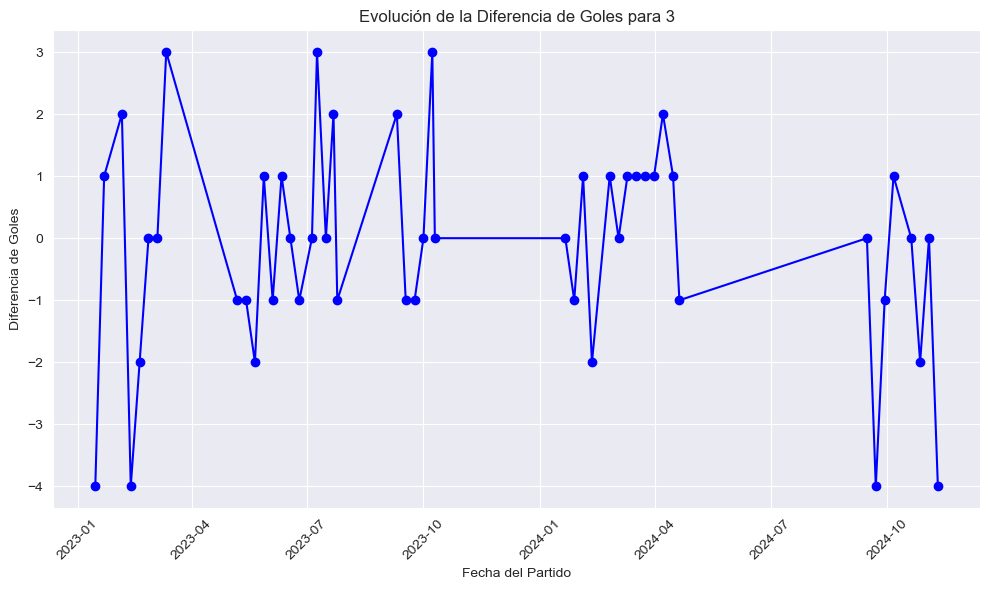

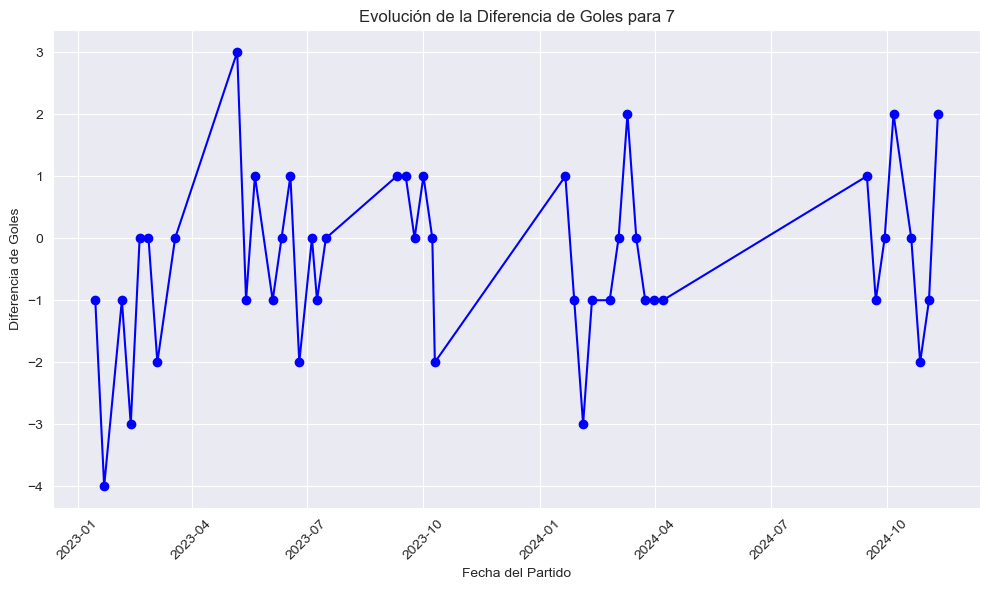

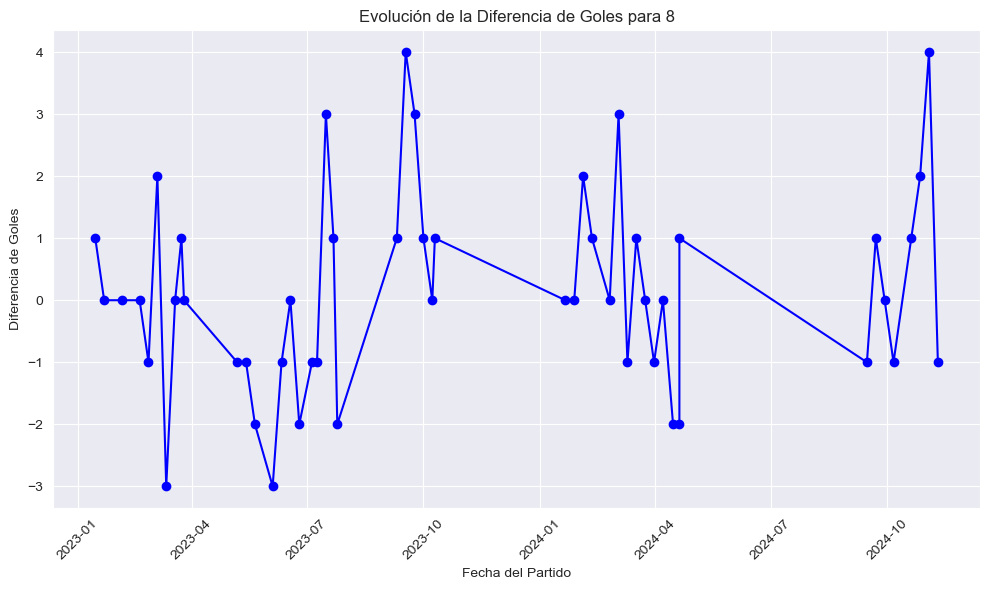

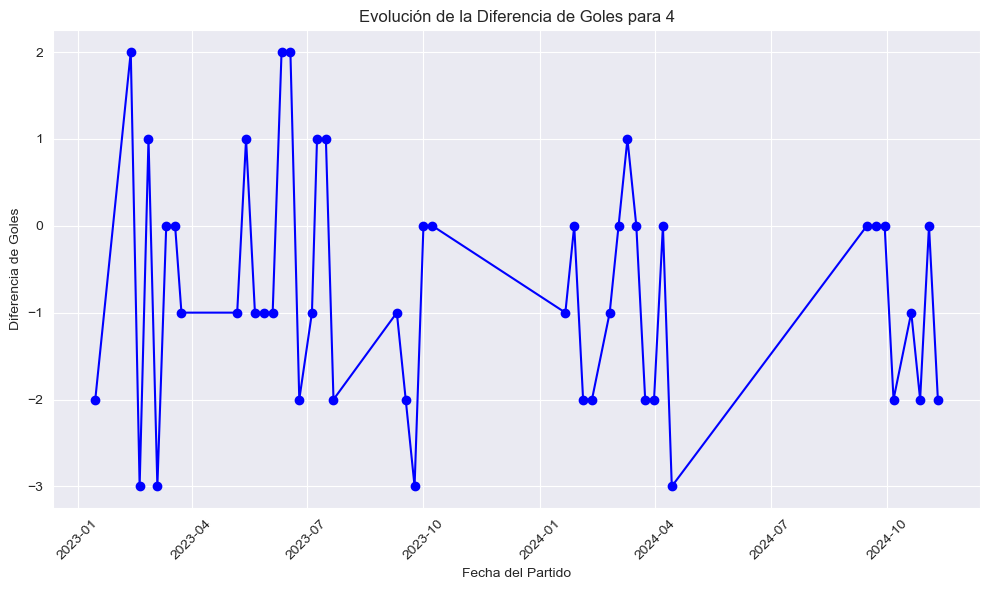

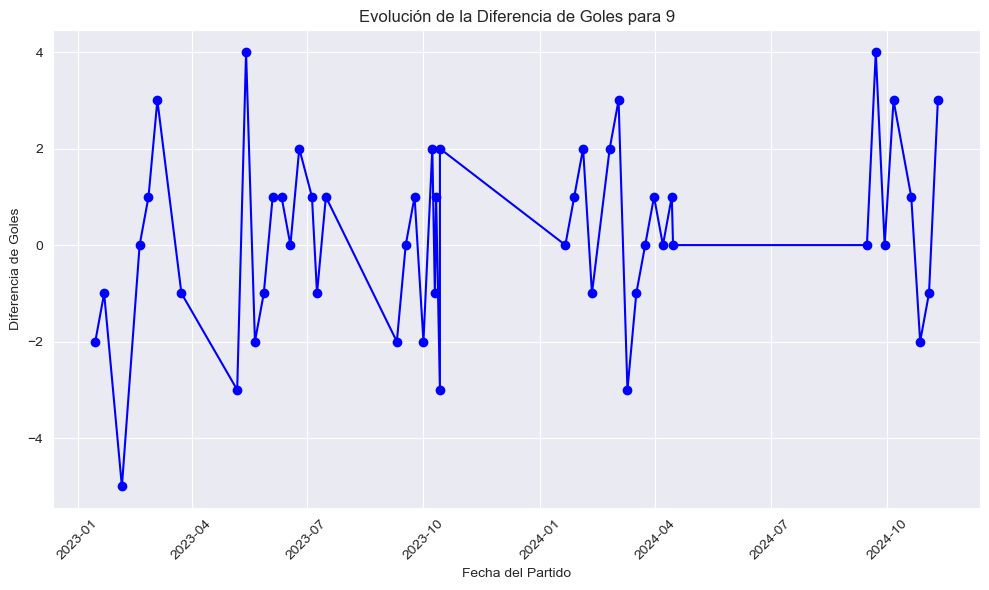

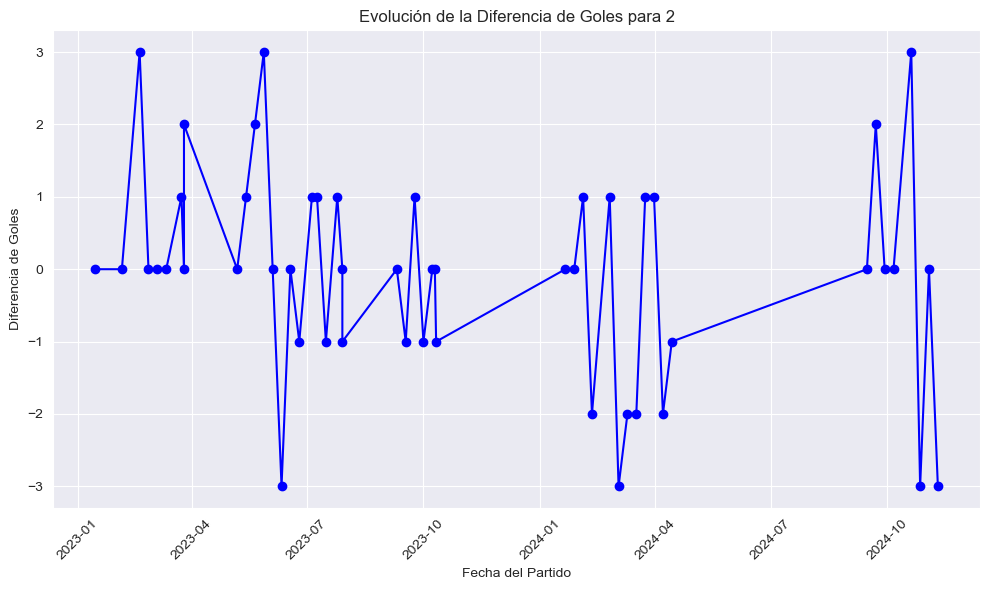

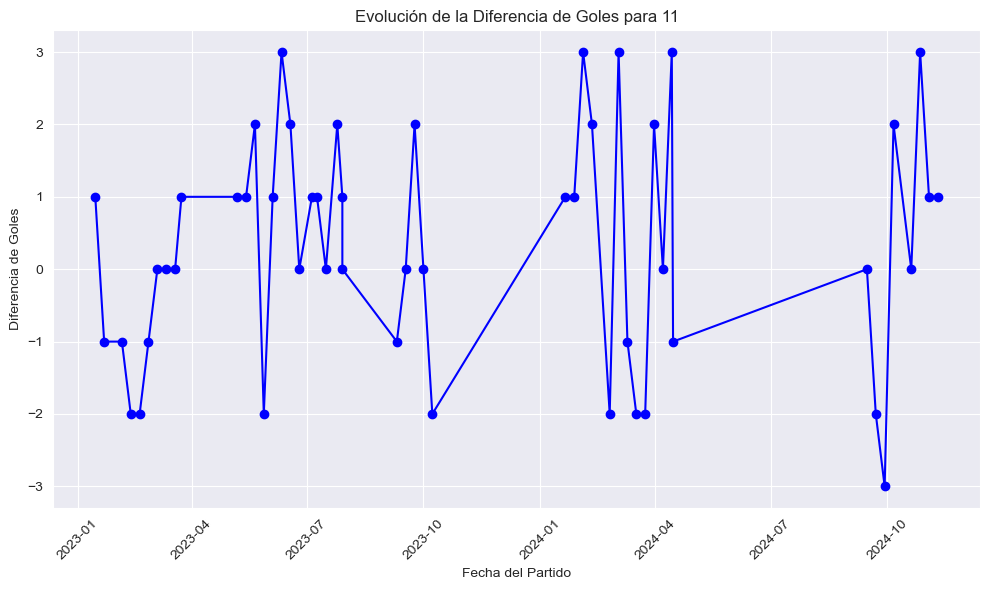

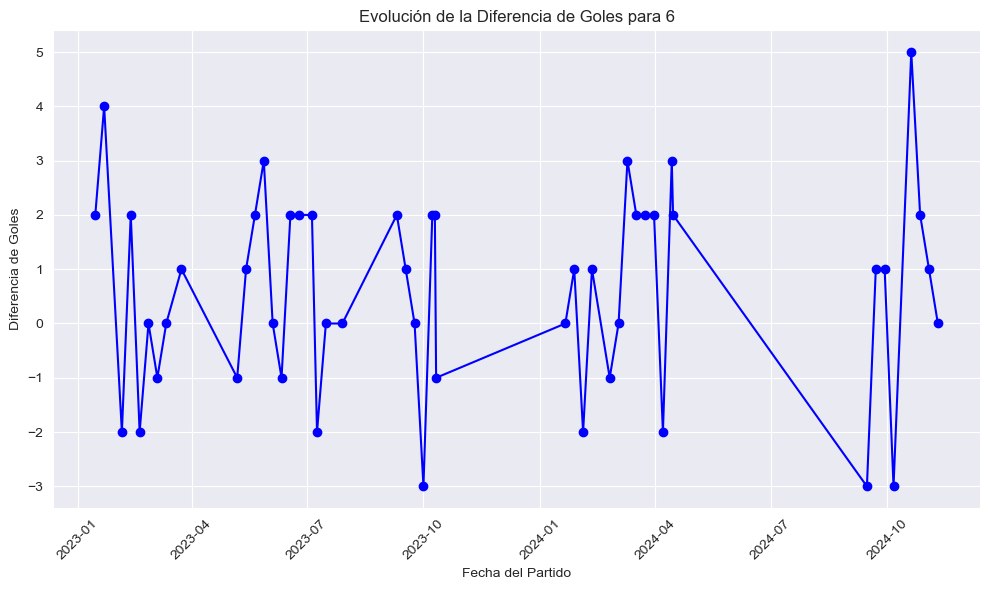

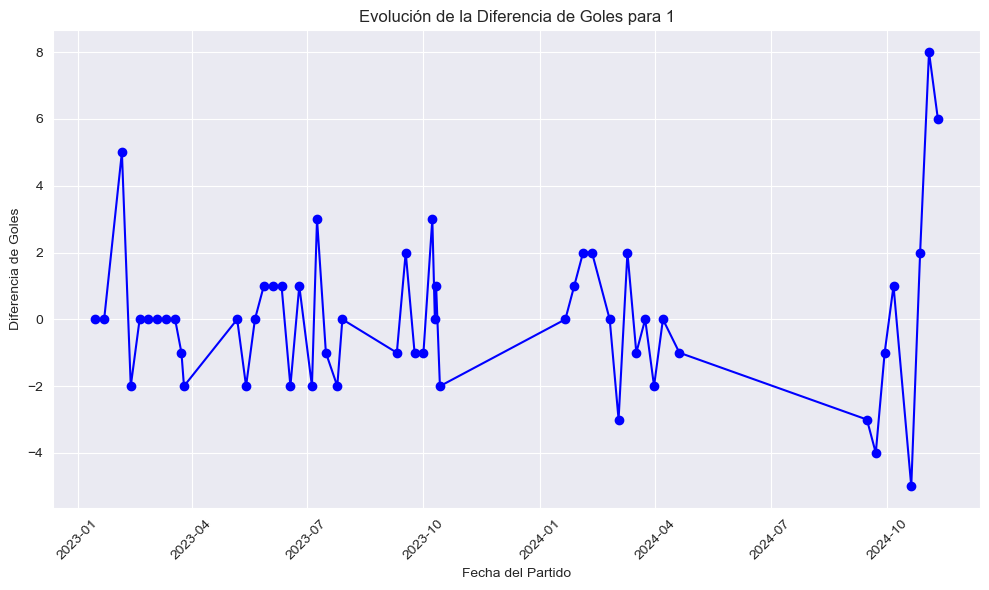

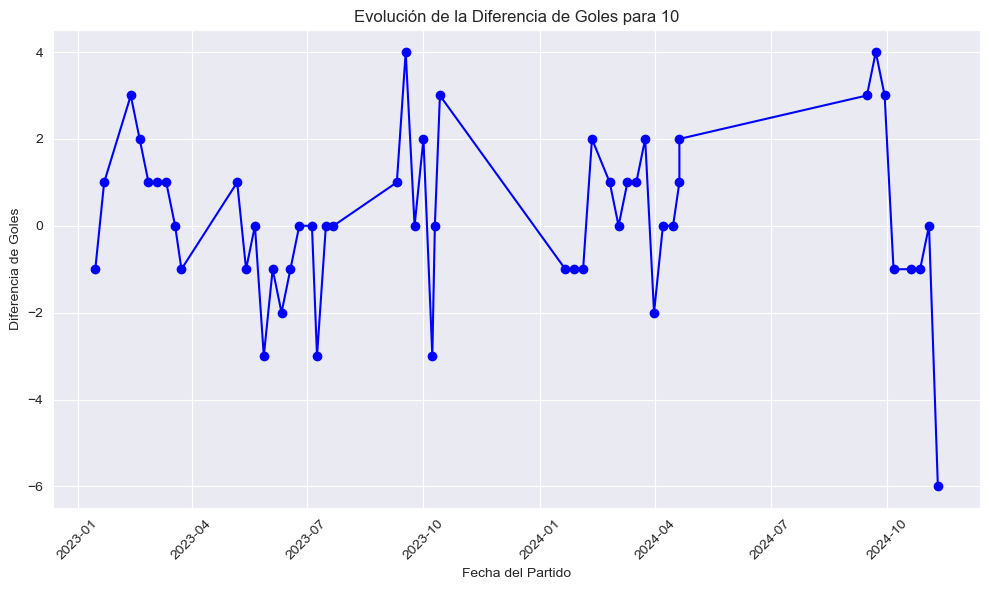

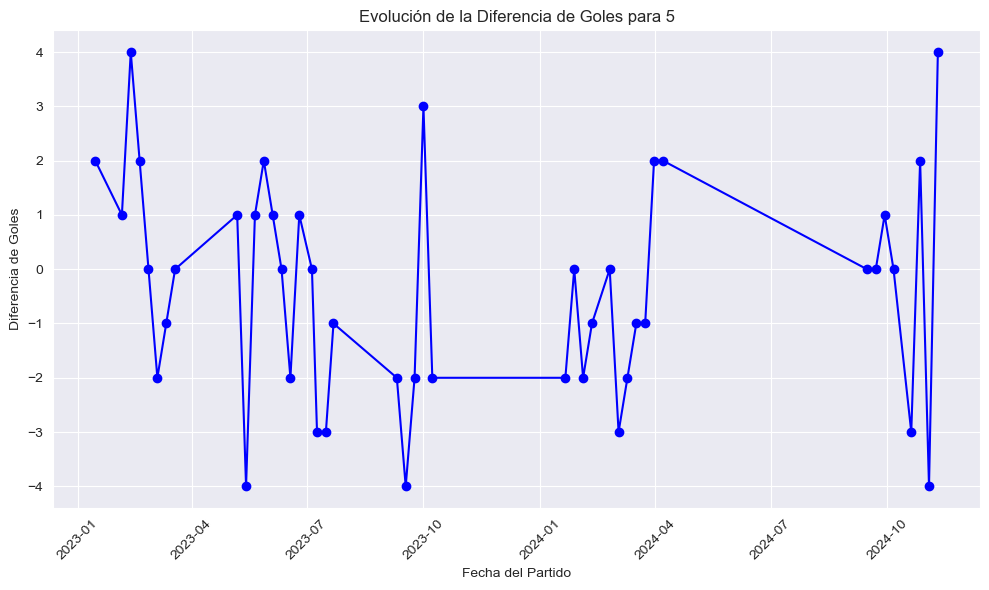

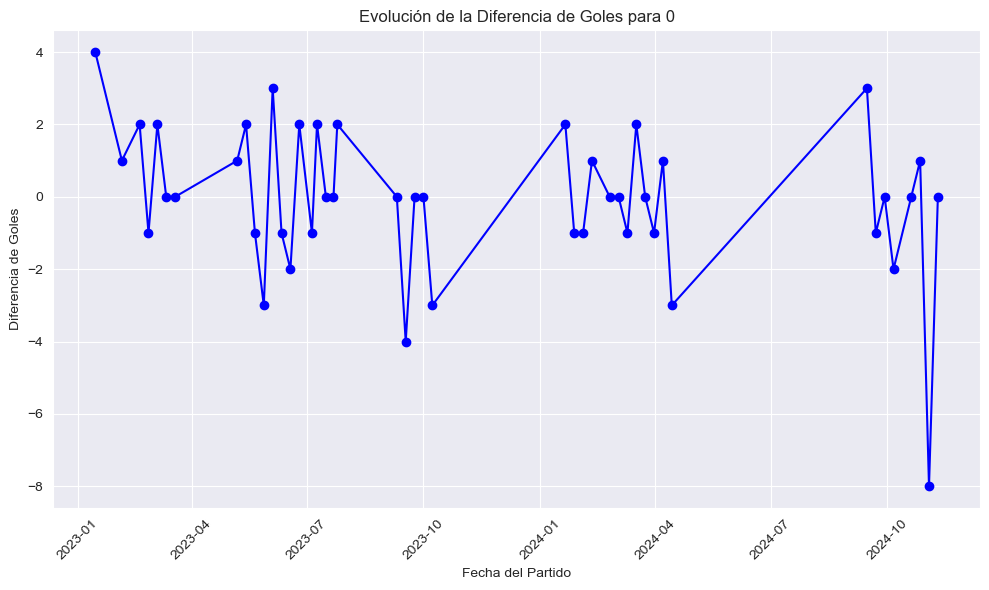

In [21]:
for team in teams:
    plt.figure(figsize=(10, 6))
    
    # Filtrar datos por equipo
    team_data = performance[performance['team'] == team]
    
    # Ordenar por fecha para asegurarse de que las líneas sean coherentes
    team_data = team_data.sort_values(by='date')

    # Graficar la evolución de la diferencia de goles por partido
    plt.plot(team_data['date'], team_data['goal_difference_dice'], marker='o', linestyle='-', color='b')
    plt.title(f'Evolución de la Diferencia de Goles para {team}')
    plt.xlabel('Fecha del Partido')
    plt.ylabel('Diferencia de Goles')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## ¿Cuál es la diferencia promedio de goles antes y después de lanzar el dado para cada equipo?

<Figure size 1200x600 with 0 Axes>

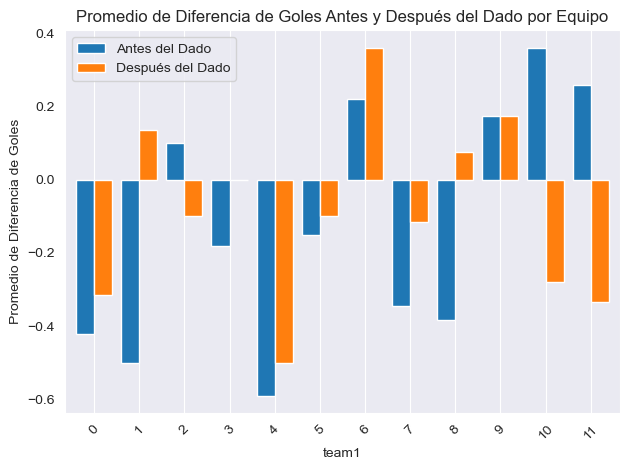

In [22]:
# Crear las columnas de diferencia de goles antes y después del dado
df['goal_difference_before_dice'] = df['goals_team1'] - df['goals_team2']
df['goal_difference_after_dice'] = df['goals_team1_after_dice'] - df['goals_team2_after_dice']

# Calcular la diferencia promedio de goles antes y después del dado para cada equipo
avg_goal_diff_per_team = df.groupby('team1')[['goal_difference_before_dice', 'goal_difference_after_dice']].mean().reset_index()
plt.figure(figsize=(12, 6))
avg_goal_diff_per_team.set_index('team1').plot(kind='bar', width=0.8)
plt.title('Promedio de Diferencia de Goles Antes y Después del Dado por Equipo')
plt.ylabel('Promedio de Diferencia de Goles')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.legend(['Antes del Dado', 'Después del Dado'])
plt.tight_layout()
plt.show()

In [23]:
avg_goal_diff_per_team 

,team1,goal_difference_before_dice,goal_difference_after_dice
0,0,-0.421053,-0.315789
1,1,-0.500000,0.136364
2,2,0.100000,-0.100000
3,3,-0.181818,0.000000
4,4,-0.590909,-0.500000
5,5,-0.150000,-0.100000
6,6,0.222222,0.361111
7,7,-0.346154,-0.115385
8,8,-0.384615,0.076923
9,9,0.173913,0.173913


## ¿Hay alguna modalidad del dado (por ejemplo, 5 vs 5, 3 vs 3) que tenga un mayor impacto en los goles marcados?

<Figure size 1200x600 with 0 Axes>

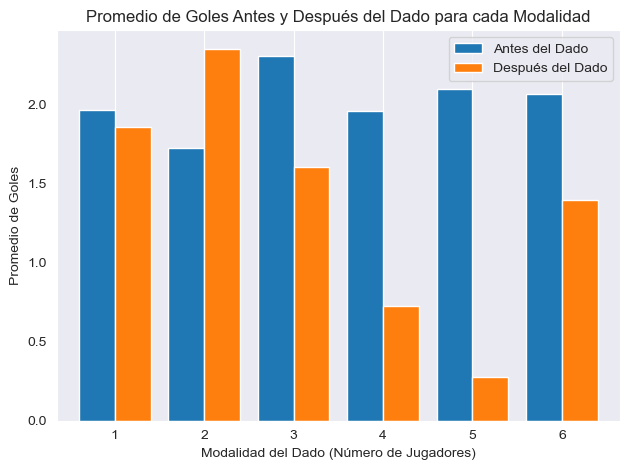

In [24]:
# Crear las columnas de goles totales antes y después del dado
df['total_goals_before_dice'] = df['goals_team1'] + df['goals_team2']
df['total_goals_after_dice'] = df['goals_team1_after_dice'] + df['goals_team2_after_dice']

# Calcular el promedio de goles antes y después del dado para cada modalidad del dado
avg_goals_per_dice_modality = df.groupby('dado_number')[['total_goals_before_dice', 'total_goals_after_dice']].mean().reset_index()

plt.figure(figsize=(12, 6))
avg_goals_per_dice_modality.set_index('dado_number').plot(kind='bar', width=0.8)
plt.title('Promedio de Goles Antes y Después del Dado para cada Modalidad')
plt.ylabel('Promedio de Goles')
plt.xlabel('Modalidad del Dado (Número de Jugadores)')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(['Antes del Dado', 'Después del Dado'])
plt.tight_layout()
plt.show()

El 2v2 es el único que marca mucho la diferencia positiva de goles, es un dado que en general es muy atractivo de ver y nos da mucho show, en cambio el 5v5 es el peor para dar espectáculo, por obvias razones es más difícil marca

In [25]:
avg_goals_per_dice_modality 

,dado_number,total_goals_before_dice,total_goals_after_dice
0,1,1.964286,1.857143
1,2,1.720930,2.348837
2,3,2.301887,1.603774
3,4,1.954545,0.727273
4,5,2.093023,0.279070
5,6,2.062500,1.395833


### Como ha cambiado los goles en el dado con el paso de los partidos, en relación también con los minutos jugados

In [ ]:
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')

In [26]:
 # Agrupar por fecha y calcular la media de goles anotados después del dado y los minutos jugados
df_time_analysis = df.groupby('date').agg({
    'goals_team1_after_dice': 'mean',
    'goals_team2_after_dice': 'mean',
    'minutes_after_dice_roll': 'mean',
    'Total_goals_in_dice': 'mean'
}).reset_index()

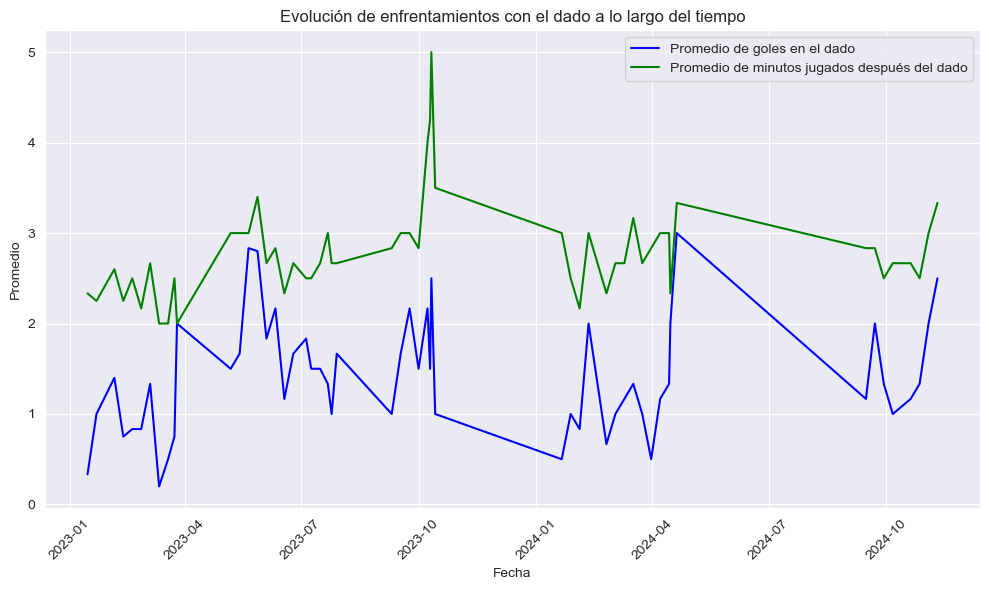

In [27]:
plt.figure(figsize=(10,6))
plt.plot(df_time_analysis['date'], df_time_analysis['Total_goals_in_dice'], label='Promedio de goles en el dado', color='blue')
plt.plot(df_time_analysis['date'], df_time_analysis['minutes_after_dice_roll'], label='Promedio de minutos jugados después del dado', color='green')

plt.xlabel('Fecha')
plt.ylabel('Promedio')
plt.title('Evolución de enfrentamientos con el dado a lo largo del tiempo')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Podemos ver que en promedio casi siempre se juegan por lo regular 3 minutos de dado, los 2 minutos de tiempo normal hasta el 20 y 1 minuto de agregado que es lo "normal" pero también hubo alguna ocasión que se extendieron hasta los 5 minutos y no fue la ocasión que más goles se marcaron tampoco. En cambio los goles marcados en promedio suelen ser entre 1 y 2, tampoco hay mucha diferencia como ya lo vimos en la diferencia de goles por equipos de goles antes y despues del dado